# Imports

In [1]:
import os

import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


from copy import deepcopy

import spacy

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier



from collections import Counter
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import ADASYN, BorderlineSMOTE

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)


# Set random seed for reproducibility
SEED=42
np.random.seed(SEED)

from utilities.funcoes import cosine_similarity, make_min_ratio_strategy, distribution, get_covid_legal_frameworks
from utilities.schema import contracts_schema, lots_schema, procedimentos_schema


# from typing import Literal
# from pydantic import BaseModel
# from langchain_ollama import ChatOllama
# from tqdm import tqdm
# from langchain_core.prompts import ChatPromptTemplate

import re
import string

import time
from pathlib import Path
from collections import Counter


c:\Users\carol\Documents\bolsa\Text_Fields\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [2]:
# already preprocessed

contratos = pl.read_parquet(
    "../../data/contratos_cleaned_prepro.parquet",
    columns=[
        "N.º Procedimento (ID BASE)", "N.º Contrato", "Tipo(s) de contrato_LIMPO", "Objeto_LIMPO", "Objeto_LIMPO_2", "Objeto", "Tipo de procedimento"
    ]
    )


procedimentos = pl.read_csv("../../data/impic_data/procedimentos.csv",
                            separator=";",
                            schema_overrides=procedimentos_schema(),
                            columns=[
                                "ContractingProcedureAliasID", "Regime de Contratação"
                                     ],
                            null_values=["NULL"]) \
                            .unique(subset="ContractingProcedureAliasID")



contratos_raw = pl.read_csv("../../data/impic_data/contratos.csv", separator=";", schema_overrides=contracts_schema(),
    columns=['N.º Procedimento (ID BASE)', 'N.º Contrato', 'Data da decisão adjudicação', 
             'Data Celebração', "Contratação Excluída", "Tipo de procedimento", "Medidas Especiais",
              "Ao abrigo dos critérios materiais", 'Preço BASE (€)', 'Preço Contratual (€)'], 
    null_values=["NULL"]) \
    .with_columns(
        pl.col("Data da decisão adjudicação").replace("NULL", None).str.split(" ").list.first().str.replace("'", "").str.to_date("%F"),
        pl.col('Data Celebração').replace("NULL", None).str.split(" ").list.first().str.replace("'", "").str.to_date("%F"),
    ) \
    .with_columns(
        pl.col("Data Celebração").dt.year().alias("contract_year")
    ) \
    .join(procedimentos, how="left", left_on="N.º Procedimento (ID BASE)", right_on="ContractingProcedureAliasID", coalesce=True) \
    .filter(pl.col("Contratação Excluída") == False) \
    .filter(pl.col("Tipo de procedimento").is_in(["Concurso público", "Concurso limitado por prévia qualificação"])) \
    .filter(pl.col("Medidas Especiais").is_null()) \
    .filter(~pl.col("Regime de Contratação").str.contains_any(get_covid_legal_frameworks())) \
    .unique(subset=['N.º Procedimento (ID BASE)', 'N.º Contrato']).select(['N.º Procedimento (ID BASE)', 'N.º Contrato', "contract_year"])


contracts_cvps = pl.read_ipc(
    "../../data/impic_data/procurement_contracts_2018_2023.arrow"
).unique(["contract_id"])

In [3]:
contratos = contratos.join(contratos_raw, how="inner", on=['N.º Procedimento (ID BASE)', 'N.º Contrato'], coalesce=True)

In [4]:
contratos = contratos.join(contracts_cvps.with_columns(pl.col("contract_id").cast(pl.Utf8)).select(["contract_id", "cpvs"]), 
                           how="left", left_on=["N.º Contrato"], right_on=["contract_id"], coalesce=True)  \
                        .with_columns(
                            pl.col("cpvs").str.slice(1, length=3),
                        )

In [5]:
contratos.select(["contract_year"]).to_pandas().value_counts()

contract_year
2021             18567
2020             17250
2019             15989
2018             10371
2022              4119
2023              2941
Name: count, dtype: int64

# Anomalies

In [6]:
pos_tagging = pl.read_csv(
    "../../data/resultados_pos_tagging.csv",
    schema_overrides={
        "N.º Procedimento (ID BASE)": pl.Utf8, 
        "N.º Contrato": pl.Utf8
    }
)

In [7]:
contratos = contratos.join(pos_tagging.select(["N.º Procedimento (ID BASE)", "N.º Contrato", "n_palavras_total"]), how="left", on=["N.º Procedimento (ID BASE)", "N.º Contrato"], coalesce=True)

In [8]:
contratos = contratos.with_columns(
    pl.when(pl.col("Objeto").str.contains("[A-Za-z]")).then(pl.lit(0)).otherwise(pl.lit(1)).alias("flag_1011_anom")
).with_columns(
    pl.when((pl.col("n_palavras_total")>300) & (pl.col("flag_1011_anom")==0)).then(pl.lit(1)).otherwise(pl.col("flag_1011_anom")).alias("flag_1011_anom")
)

In [9]:
# contratos.filter(
#     pl.col("flag_1011_anom")==1
# ).select(["flag_1011_anom", "N.º Procedimento (ID BASE)", "N.º Contrato"]).write_csv("../../data/resultados_anomalias.csv")

# Read embeddings

In [10]:
## READ EMBEDDINGS

embeddings_serafim_objeto = pl.read_parquet("../../data/embeddings/serafim/Objeto_LIMPO.parquet")
embeddings_serafim_tipo = pl.read_parquet("../../data/embeddings/serafim/Tipo(s) de contrato_LIMPO.parquet")

embeddings_labse_objeto = pl.read_parquet("../../data/embeddings/labse/Objeto_LIMPO.parquet")
embeddings_labse_tipo = pl.read_parquet("../../data/embeddings/labse/Tipo(s) de contrato_LIMPO.parquet")

In [11]:
embeddings_serafim_objeto.shape

(937860, 1026)

In [12]:
# tirar tipos de contratos minoritários que nem sequer apareceram no ccp, literalmente não quero saber e ninguém me vai perguntar
# tirar contratos que têm um objeto com dimensão superior a 300, porque isso nem são objetos, são clausulas do cadderno de encargos
contratos = contratos.filter(
    (pl.col("Tipo(s) de contrato_LIMPO")!="outros") & (pl.col("Tipo(s) de contrato_LIMPO")!="sociedade")
)

In [13]:
contratos = contratos.filter(
    pl.col("flag_1011_anom")==0
)

In [14]:
embeddings_serafim_objeto = embeddings_serafim_objeto.join(
    contratos,
    on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
    how = "semi"
)
embeddings_serafim_tipo = embeddings_serafim_tipo.join(
    contratos,
    on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
    how = "semi"
)
embeddings_labse_objeto = embeddings_labse_objeto.join(
    contratos,
    on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
    how = "semi"
)
embeddings_labse_tipo = embeddings_labse_tipo.join(
    contratos,
    on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
    how = "semi"
)

In [15]:
# y = contratos.select(pl.col('Tipo(s) de contrato_LIMPO')).to_numpy()
# idx = np.arange(len(y))

# # train_test_split before the real model
# idx_train_val, idx_test = train_test_split(
#     idx,
#     test_size=0.2,
#     random_state=SEED,
#     stratify=y,
#     shuffle=True
# )

# 2011 indicator - first

## 2. Flag objects that are too similar to the contract type

In [16]:
# até ao final do dia de hoje quero ter esta experimentação

cos_serafim = cosine_similarity(embeddings_serafim_tipo.drop(["N.º Procedimento (ID BASE)", "N.º Contrato"]), embeddings_serafim_objeto.drop(["N.º Procedimento (ID BASE)", "N.º Contrato"]))
cos_labse = cosine_similarity(embeddings_labse_tipo.drop(["N.º Procedimento (ID BASE)", "N.º Contrato"]), embeddings_labse_objeto.drop(["N.º Procedimento (ID BASE)", "N.º Contrato"]))

contratos = contratos.with_columns(
    pl.Series("dist_serafim_obj_tipo", cos_serafim),
    pl.Series("dist_labse_obj_tipo", cos_labse)
)

In [17]:
# para evitar leakage temporal
contratos_below_22 = contratos.filter((pl.col("contract_year")!=2022) & (pl.col("contract_year")!=2023))

In [18]:
# Calcular a média dos embeddings por tipo, só usando contratos anteriores a 2022

embeddings_labse_objeto_below_22 = embeddings_labse_objeto.join(contratos_below_22.select(["N.º Procedimento (ID BASE)", "N.º Contrato", "cpvs"]), 
                                               how="inner", on = ["N.º Procedimento (ID BASE)", "N.º Contrato"],
                                               coalesce=True)


embeddings_labse_objeto = embeddings_labse_objeto.join(contratos.select(["N.º Procedimento (ID BASE)", "N.º Contrato", "cpvs"]), 
                                               how="left", on = ["N.º Procedimento (ID BASE)", "N.º Contrato"],
                                               coalesce=True)

embedding_cols = [c for c in embeddings_labse_objeto_below_22.columns if c not in ["N.º Procedimento (ID BASE)", "N.º Contrato", "cpvs"]]

centroides = embeddings_labse_objeto_below_22.group_by(["cpvs"]).agg([pl.col(c).mean().alias(c) for c in embedding_cols])

In [19]:
tipos_lista = contratos.select(["cpvs"]).unique().to_series().to_list()

In [20]:
dot = pl.sum_horizontal(
    pl.col(c) * pl.col(f"{c}_tipo")
    for c in embedding_cols
)

norm_x = pl.sum_horizontal(
    pl.col(c) ** 2
    for c in embedding_cols
).sqrt()

norm_t = pl.sum_horizontal(
    pl.col(f"{c}_tipo") ** 2
    for c in embedding_cols
).sqrt()

In [21]:
df_result = embeddings_labse_objeto.join(
    centroides,
    on="cpvs",
    how="left",
    suffix="_tipo", 
    coalesce=True
).with_columns(
    (1 - dot / (norm_x * norm_t)).alias("dist_to_centroide")
).select(['N.º Procedimento (ID BASE)',
 'N.º Contrato', 'dist_to_centroide', "cpvs"])

In [22]:
df_result

N.º Procedimento (ID BASE),N.º Contrato,dist_to_centroide,cpvs
str,str,f64,str
"""5255405""","""8761625""",0.254587,"""168"""
"""3738219""","""5229550""",0.252728,"""461"""
"""5238736""","""7729484""",0.22678,"""990"""
"""4485248""","""6616531""",0.140681,"""031"""
"""4189184""","""6062822""",0.129653,"""019"""
…,…,…,…
"""4984086""","""7508593""",0.167002,"""314"""
"""4280463""","""6457887""",0.217498,"""520"""
"""4121949""","""5994146""",0.275668,"""514"""


In [23]:
contratos = contratos.join(df_result, how="left", on=['N.º Procedimento (ID BASE)', 'N.º Contrato'], coalesce=True)

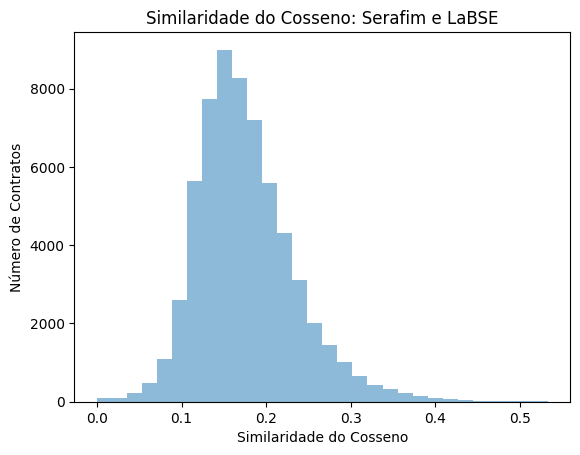

In [24]:
plt.figure()

dist = contratos.filter(pl.col("contract_year")<2022).select(["dist_to_centroide"]).to_pandas()

# Histogramas (guardar handles)
dist_plot = plt.hist(dist, bins=30, alpha=0.5)

plt.xlabel("Similaridade do Cosseno")
plt.ylabel("Número de Contratos")
plt.title(f"Similaridade do Cosseno: Serafim e LaBSE")

plt.show()

In [25]:
quantile_95 = contratos.filter(pl.col("contract_year")<2022).select(
    pl.col("dist_to_centroide").quantile(0.95)
).item()

quantile_99 = contratos.filter(pl.col("contract_year")<2022).select(
    pl.col("dist_to_centroide").quantile(0.99)
).item()

In [26]:
contratos = contratos.with_columns(
    pl.when(pl.col("dist_to_centroide") > quantile_99).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_centroide_99"),
    pl.when(pl.col("dist_to_centroide") > quantile_95).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_centroide_95")
)

In [35]:
contratos.select(['N.º Procedimento (ID BASE)',
 'N.º Contrato',
 'Tipo(s) de contrato_LIMPO',
 'Objeto_LIMPO',
 'Objeto_LIMPO_2',
 'cpvs', 'dist_to_centroide']).write_csv("../../data/results_dist_centroide.csv")

In [ ]:
# Próximo objetivo - sinalizar os objetos contratuais que distam muito do do seu tipo, mas separado por tipo de contrato

# Está a dar resultados bastante maus lol este próximo passp

In [30]:
mean_std = contratos_below_22.group_by(["Tipo(s) de contrato_LIMPO"]).agg(pl.col("dist_serafim_obj_tipo").mean().alias("mean_serafim"), 
                                                               pl.col("dist_labse_obj_tipo").mean().alias("mean_labse"),
                                                               pl.col("dist_serafim_obj_tipo").std().alias("std_serafim"), 
                                                               pl.col("dist_labse_obj_tipo").std().alias("std_labse"))

contratos = contratos.join(mean_std, how="left", on = ["Tipo(s) de contrato_LIMPO"], coalesce=True) \
                        .with_columns(
                            pl.when(((pl.col("dist_labse_obj_tipo") < (pl.col("mean_labse") - 3.5 * pl.col("std_labse")))
                                     | (pl.col("dist_labse_obj_tipo")> (pl.col("mean_labse") + 3.5 * pl.col("std_labse")))))
                            .then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_labse_dist"),
                            
                            pl.when((pl.col("dist_serafim_obj_tipo") < (pl.col("mean_serafim") - 3.5 * pl.col("std_serafim"))) 
                                    | (pl.col("dist_serafim_obj_tipo")> (pl.col("mean_serafim") + 3.5 * pl.col("std_serafim"))))
                            .then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_serafim_dist")
                        
                        )

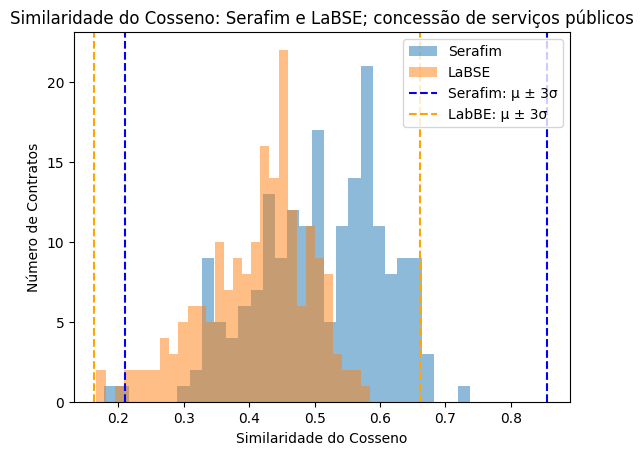

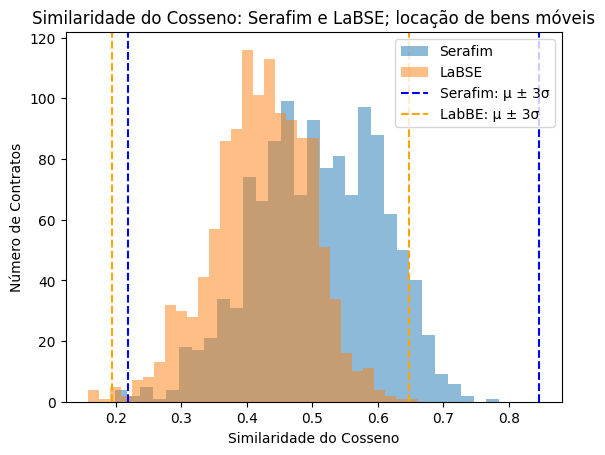

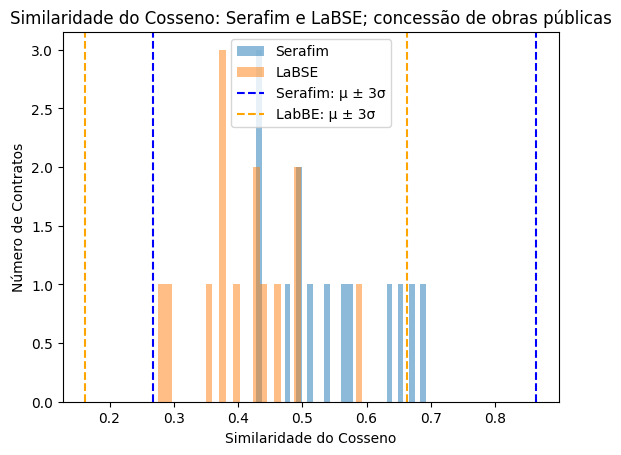

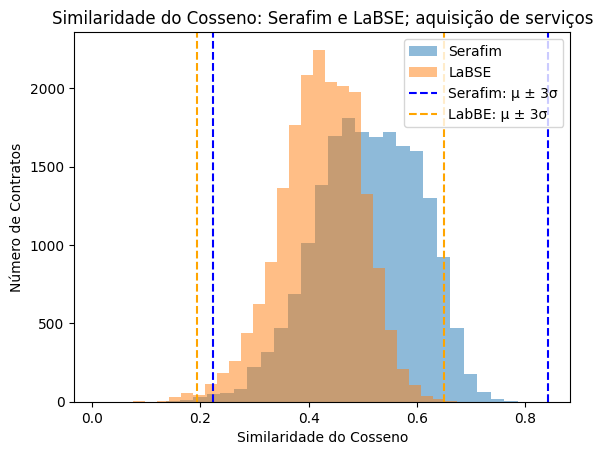

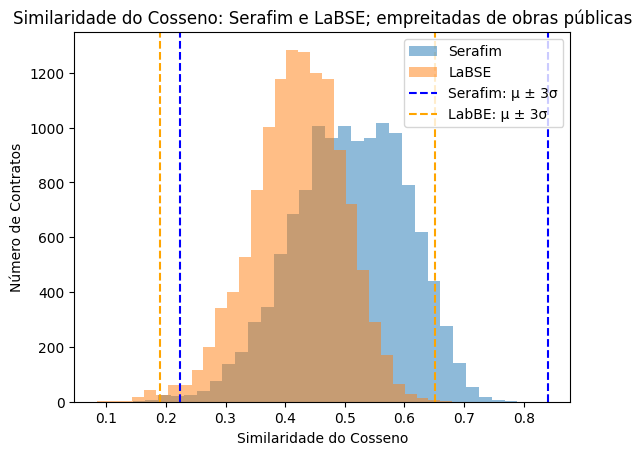

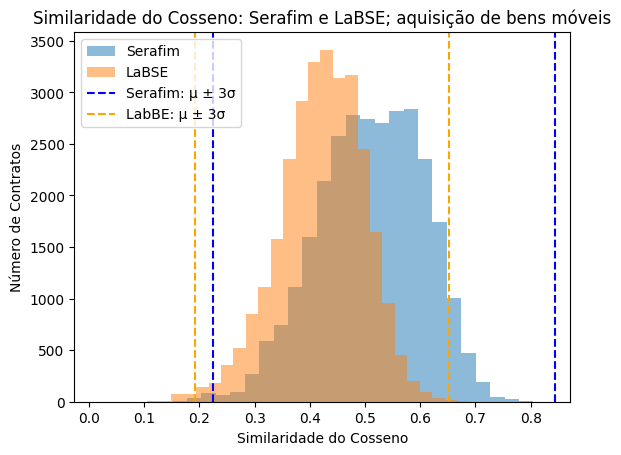

In [50]:
for tipo in tipos_lista:
    serafim = contratos_below_22.filter(pl.col("Tipo(s) de contrato_LIMPO")==tipo).select(["dist_serafim_obj_tipo"]).to_pandas()
    labse = contratos_below_22.filter(pl.col("Tipo(s) de contrato_LIMPO")==tipo).select(["dist_labse_obj_tipo"]).to_pandas()

    mean_s, std_s = serafim.mean().item(), serafim.std().item()
    mean_l, std_l = labse.mean().item(), labse.std().item()

    plt.figure()


    # Histogramas (guardar handles)
    h_serafim = plt.hist(serafim, bins=30, alpha=0.5)
    h_labse = plt.hist(labse, bins=30, alpha=0.5)


    # Limites ±3σ (guardar handles)
    line_s_1 = plt.axvline(mean_s - 3 * std_s, linestyle="--", color="blue")
    line_s_2 = plt.axvline(mean_s + 3.5 * std_s, linestyle="--", color="blue")

    line_l_1 = plt.axvline(mean_l - 3 * std_l, linestyle="--", color="orange")
    line_l_2 = plt.axvline(mean_l + 3 * std_l, linestyle="--", color="orange")

    plt.xlabel("Similaridade do Cosseno")
    plt.ylabel("Número de Contratos")
    plt.title(f"Similaridade do Cosseno: Serafim e LaBSE; {tipo}")


    # Legenda correta (1 linha representativa por distribuição)
    plt.legend(
        [h_serafim[2][0], h_labse[2][0], line_s_1, line_l_1],
        ["Serafim", "LaBSE", "Serafim: µ ± 3σ", "LabBE: µ ± 3σ"]
    )

    plt.show()

In [ ]:
# Calcular a distribuição da distância por tipo

contratos.group_by("Tipo(s) de contrato_LIMPO").agg(pl.col("dist_serafim_obj_tipo"))

Tipo(s) de contrato_LIMPO,dist_serafim_obj_tipo
str,f64
"""concessão de obras públicas""",0.542523
"""concessão de serviços públicos""",0.512575
"""locação de bens móveis""",0.510206
"""empreitadas de obras públicas""",0.508068
"""aquisição de bens móveis""",0.510148
"""aquisição de serviços""",0.508988


In [ ]:
# preciso de trabalhar na questão dos intervalos de confiança, isto não é uma boa métrica

from typing import List

def extract_sliding_windows(years: np.ndarray, window_shape: int) -> List[np.ndarray]:
    """Extracts sliding windows from an array of years

    In case where the number of years is less than the window size, the function returns a truncated array.
    
    Example:
        >>> extract_sliding_windows(np.array([2023, 2022, 2021, 2020]), 3)
        >>> [array([2023, 2022, 2021]), array([2022, 2021, 2020]), array([2021, 2020]), array([2020])]
    
    Args:
        years (np.ndarray): An array of years, descending order (i.e. higher years have lower indexes)
        window_shape (int): The window size to be considered

    Returns:
        np.ndarray: An array of arrays, where the sub-arrays are sliding windows over the years
    """

    windows = []

    for i in range(0, np.size(years)):
        if i+window_shape < np.size(years):
            windows.append(years[i:i+window_shape])
        else:
            windows.append(years[i:])
            
    return windows


def reverse_order_unique_contract_years(contracts_table: pl.DataFrame, contract_year_column_name: str) -> np.ndarray:
    """Extracts unique years in descending order from a pl.DataFrame column

    Args:
        contracts_table (pl.DataFrame): The contracts table holding a column with contract years
        contract_year_column_name (str): The name of the column holding contract years

    Returns:
        np.ndarray: An array of contract years in descending order
    """
    unique_years = contracts_table \
        .filter(pl.col(contract_year_column_name).is_not_null()) \
        .unique(subset=[contract_year_column_name]) \
        .select(contract_year_column_name) \
        .to_numpy() \
        .flatten()
    
    return np.sort(unique_years)[::-1]


def mean_per_year_per_cpv(contracts: pl.DataFrame, window: np.array, contract_year_column: str = "contract_year") -> pl.DataFrame:

    # para cada window quero filtrar pelo intervalo e calcular a média
    return contracts.filter((pl.col(contract_year_column)>=window[-1]) & (pl.col(contract_year_column)<=window[0])) \
                .group_by(["cpvs"]) \
                .agg((pl.col("Preço Contratual (€)").mean().round(3)).alias("Preço Estimado")) \
                .with_columns(
                    pl.lit(window[0]).alias("end_period").cast(pl.Int64)
                )

In [ ]:
extract_sliding_windows(reverse_order_unique_contract_years(contratos, "contract_year"), 3)

[array([2023, 2022, 2021], dtype=int32),
 array([2022, 2021, 2020], dtype=int32),
 array([2021, 2020, 2019], dtype=int32),
 array([2020, 2019, 2018], dtype=int32),
 array([2019, 2018], dtype=int32),
 array([2018], dtype=int32)]

In [46]:
def flag_object(contracts_table) -> pl.DataFrame:
    confidence_int = pl.concat(
    get_confidence_interval(contracts_table, window, "contract_year") for window in extract_sliding_windows(reverse_order_unique_contract_years(contratos, "contract_year"), 3)
)

    return contracts_table \
        .join(confidence_int, how="left", left_on=["cpvs", "contract_year"], right_on=["cpvs", "period_end_year"], coalesce=True) \
        .with_columns(
            pl.when((pl.col("dist_serafim_obj_tipo") > pl.col("confidence_95_upper_serafim")) | (pl.col("dist_serafim_obj_tipo") < pl.col("confidence_95_lower_serafim"))).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_serafim"),
                pl.when((pl.col("dist_labse_obj_tipo") > pl.col("confidence_95_upper_labse")) | (pl.col("dist_labse_obj_tipo") < pl.col("confidence_95_lower_labse"))).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_labse")
        )

In [47]:
flag_object(contratos).filter(pl.col("flag_serafim")==1)

N.º Procedimento (ID BASE),N.º Contrato,Tipo(s) de contrato_LIMPO,Objeto_LIMPO,Objeto_LIMPO_2,Objeto,Tipo de procedimento,contract_year,cpvs,Objeto_LIMPO_Final,objeto_len,flag_1011_anom,dist_serafim_obj_tipo,dist_labse_obj_tipo,confidence_95_upper_serafim,confidence_95_lower_serafim,confidence_95_upper_labse,confidence_95_lower_labse,flag_serafim,flag_labse
str,str,str,str,str,str,str,i32,str,str,i64,i32,f64,f64,f64,f64,f64,f64,i32,i32
"""3738219""","""5229550""","""aquisição de bens móveis""","""aquisição de 600 (seiscentos) …","""aquisição seiscentos proteções…","""Aquisição de 600 (seiscentos) …","""Concurso público""",2019,"""461""","""aquisição de 600 seiscentos pr…",42,0,0.498268,0.490194,0.539056,0.502538,0.435693,0.401167,1,1
"""4485248""","""6616531""","""aquisição de serviços""","""manutenção/assistência técnica…","""manutençãoassistência técnica …","""Manutenção/assistência técnica…","""Concurso público""",2020,"""031""","""manutenção assistência técnica…",7,0,0.510885,0.387302,0.48596,0.4231,0.418771,0.388586,1,1
"""4189184""","""6062822""","""aquisição de bens móveis""","""aquisição de pastas, dossiers …","""aquisição pastas dossiers afin…","""aquisição de pastas, dossiers …","""Concurso público""",2019,"""019""","""aquisição de pastas dossiers e…",10,0,0.423578,0.400336,0.474983,0.442043,0.409151,0.380135,1,0
"""4472078""","""6747000""","""aquisição de bens móveis""","""1900017/2020- contratação de a…","""contratação ajudas técnicas ch…","""1900017/2020- Contratação de A…","""Concurso público""",2020,"""319""","""1900017 2020 contratação de aj…",11,0,0.599621,0.435063,0.552872,0.527812,0.44658,0.428328,1,0
"""3730843""","""5333896""","""empreitadas de obras públicas""","""remodelação do jardim josé mar…","""remodelação jardim josé maria …","""Remodelação do Jardim José Mar…","""Concurso público""",2019,"""523""","""remodelação do jardim josé mar…",10,0,0.622057,0.478503,0.548924,0.540581,0.447459,0.441749,1,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""4984086""","""7508593""","""aquisição de bens móveis""","""mcc - material para a especial…","""mcc material especialidade gas…","""MCC - Material para a especial…","""Concurso público""",2021,"""314""","""mcc material para a especialid…",16,0,0.617771,0.478709,0.526583,0.519172,0.437986,0.431219,1,1
"""4280463""","""6457887""","""empreitadas de obras públicas""","""en3, km 182+752, ph; en241-1, …","""pontão caniçal cimeiro sarnada…","""EN3, KM 182+752, PH; EN241-1, …","""Concurso público""",2020,"""520""","""en3 km 182 752 ph en241 1 km 4…",26,0,0.591755,0.491406,0.577315,0.551898,0.452627,0.43255,1,1
"""4121949""","""5994146""","""aquisição de serviços""","""concurso publico 190009/2019""","""concurso publico""","""Concurso Publico 190009/2019""","""Concurso público""",2019,"""514""","""concurso publico 190009 2019""",4,0,0.547019,0.481343,0.513382,0.469317,0.416826,0.383224,1,1


In [28]:
contratos.group_by(["cpvs", "contract_year"]).agg(pl.col("dist_serafim_obj_tipo").mean())

cpvs,contract_year,dist_serafim_obj_tipo
str,i32,f64
"""376""",2020,0.510003
"""522""",2020,0.550622
"""995""",2018,0.504405
"""514""",2019,0.491349
"""296""",2020,0.563837
…,…,…
"""920""",2021,0.546772
"""942""",2019,0.419428
"""544""",2022,0.561048


In [38]:
contratos_to_pandas = contratos.select(["dist_serafim_obj_tipo", "dist_labse_obj_tipo"]).to_pandas()

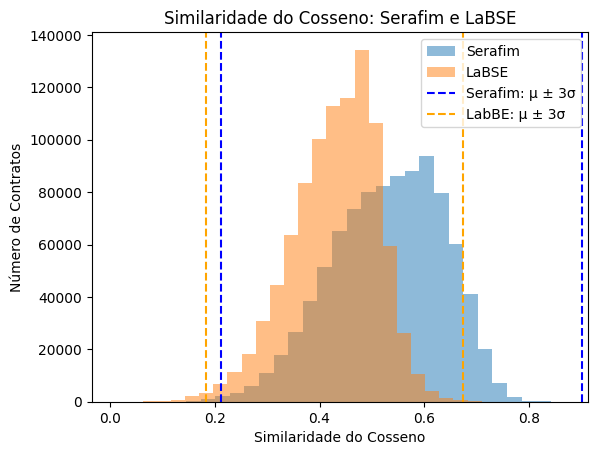

In [39]:
serafim =  contratos_to_pandas["dist_serafim_obj_tipo"]
labse =  contratos_to_pandas["dist_labse_obj_tipo"]

mean_s, std_s = serafim.mean(), serafim.std()
mean_l, std_l = labse.mean(), labse.std()

plt.figure()


# Histogramas (guardar handles)
h_serafim = plt.hist(serafim, bins=30, alpha=0.5)
h_labse = plt.hist(labse, bins=30, alpha=0.5)


# Limites ±3σ (guardar handles)
line_s_1 = plt.axvline(mean_s - 3 * std_s, linestyle="--", color="blue")
line_s_2 = plt.axvline(mean_s + 3.5 * std_s, linestyle="--", color="blue")

line_l_1 = plt.axvline(mean_l - 3 * std_l, linestyle="--", color="orange")
line_l_2 = plt.axvline(mean_l + 3 * std_l, linestyle="--", color="orange")

plt.xlabel("Similaridade do Cosseno")
plt.ylabel("Número de Contratos")
plt.title("Similaridade do Cosseno: Serafim e LaBSE")


# Legenda correta (1 linha representativa por distribuição)
plt.legend(
    [h_serafim[2][0], h_labse[2][0], line_s_1, line_l_1],
    ["Serafim", "LaBSE", "Serafim: µ ± 3σ", "LabBE: µ ± 3σ"]
)

plt.show()


In [45]:
idx_train_val_set = set(idx_train_val)
idx_test_set = set(idx_test)

contratos_train_val = (
    contratos
    .with_row_index("row_id")
    .filter(pl.col("row_id").is_in(idx_train_val_set))
    .drop("row_id")
)

contratos_test = (
    contratos
    .with_row_index("row_id")
    .filter(pl.col("row_id").is_in(idx_test_set))
    .drop("row_id")
)

In [46]:
# estatísticas iguas para treino e teste - sem leakage

k = 3.5

stats = contratos_train_val.select([
    pl.col("dist_serafim_obj_tipo").mean().alias("mu_serafim"),
    pl.col("dist_serafim_obj_tipo").std().alias("sigma_serafim"),
    pl.col("dist_labse_obj_tipo").mean().alias("mu_labse"),
    pl.col("dist_labse_obj_tipo").std().alias("sigma_labse"),
]).row(0)

mu_serafim, sigma_serafim, mu_labse, sigma_labse = stats
upper_serafim, lower_serafim = mu_serafim + k*sigma_serafim, mu_serafim - k*sigma_serafim
upper_labse,  lower_labse  = mu_labse  + k*sigma_labse,  mu_labse  - k*sigma_labse

In [48]:
contratos_train_val = contratos_train_val.with_columns([
    pl.when(
        (pl.col("dist_serafim_obj_tipo").is_between(lower_serafim, upper_serafim).not_())
    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_1011_serafim"),

    pl.when(
        (pl.col("dist_labse_obj_tipo").is_between(lower_labse, upper_labse).not_())
    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_1011_labse"),
])


In [49]:
contratos_test = contratos_test.with_columns([
    pl.when(
        (pl.col("dist_serafim_obj_tipo").is_between(lower_serafim, upper_serafim).not_())
    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_1011_serafim"),

    pl.when(
        (pl.col("dist_labse_obj_tipo").is_between(lower_labse, upper_labse).not_())
    ).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_1011_labse"),
])

In [72]:
k = 3.5
TYPE_COL = "Tipo(s) de contrato_LIMPO"

# 1) calcular estatísticas NO TREINO, por tipo (e por modelo)
stats_by_type = (
    contratos_train_val
    .group_by(TYPE_COL)
    .agg([
        pl.col("dist_serafim_obj_tipo").mean().alias("mu_serafim"),
        pl.col("dist_serafim_obj_tipo").std().alias("sigma_serafim"),
        pl.col("dist_labse_obj_tipo").mean().alias("mu_labse"),
        pl.col("dist_labse_obj_tipo").std().alias("sigma_labse"),
        pl.len().alias("n_tipo"),
    ])
    # std pode dar null se n_tipo==1; evita limites null
    .with_columns([
        pl.col("sigma_serafim").fill_null(0.0).alias("sigma_serafim"),
        pl.col("sigma_labse").fill_null(0.0).alias("sigma_labse"),
    ])
    .with_columns([
        (pl.col("mu_serafim") - k * pl.col("sigma_serafim")).alias("lower_serafim"),
        (pl.col("mu_serafim") + k * pl.col("sigma_serafim")).alias("upper_serafim"),
        (pl.col("mu_labse")   - k * pl.col("sigma_labse")).alias("lower_labse"),
        (pl.col("mu_labse")   + k * pl.col("sigma_labse")).alias("upper_labse"),
    ])
    .select([
        TYPE_COL,
        "mu_serafim", "sigma_serafim", "lower_serafim", "upper_serafim",
        "mu_labse",   "sigma_labse",   "lower_labse",   "upper_labse",
        "n_tipo"
    ])
)

# 2) aplicar flags ao treino (sem leakage): join pelas estatísticas do treino
contratos_train_val = (
    contratos_train_val
    .join(stats_by_type, on=TYPE_COL, how="left", coalesce=True)
    .with_columns([
        pl.when(
            pl.col("dist_serafim_obj_tipo").is_between(
                pl.col("lower_serafim"), pl.col("upper_serafim")
            ).not_()
        ).then(1).otherwise(0).alias("flag_1011_serafim"),

        pl.when(
            pl.col("dist_labse_obj_tipo").is_between(
                pl.col("lower_labse"), pl.col("upper_labse")
            ).not_()
        ).then(1).otherwise(0).alias("flag_1011_labse"),
    ])
)

In [73]:
contratos_test = (
    contratos_test
    .join(stats_by_type, on=TYPE_COL, how="left", coalesce=True)
    .with_columns([
        pl.when(
            pl.col("dist_serafim_obj_tipo").is_between(
                pl.col("lower_serafim"), pl.col("upper_serafim")
            ).not_()
        ).then(1).otherwise(0).alias("flag_1011_serafim"),

        pl.when(
            pl.col("dist_labse_obj_tipo").is_between(
                pl.col("lower_labse"), pl.col("upper_labse")
            ).not_()
        ).then(1).otherwise(0).alias("flag_1011_labse"),
    ])
)

In [74]:
contratos_test.filter(pl.col("flag_1011_serafim")==1).select(["Objeto_LIMPO", "dist_serafim_obj_tipo", "Tipo(s) de contrato_LIMPO", "objeto_len"]).to_pandas().values[:20]

array([['compra e venda de bens móveis', 0.1286967184239044,
        'aquisição de bens móveis', 6],
       ['aquisição de bens móveis "equipamento informático - computadores"',
        0.15893550287913116, 'aquisição de bens móveis', 7],
       ['aquisição de serviços', 0.03301373824626386,
        'aquisição de serviços', 3],
       ['empreitada de obra pública designada por remodelação interior e criação de novos espaços administrativos',
        0.2567946455368967, 'empreitadas de obras públicas', 14],
       ['aquisição de serviços', 0.04078671077189966,
        'aquisição de serviços', 3],
       ['aquisição de mobiliário', 0.15170101136374003,
        'aquisição de bens móveis', 3],
       ['locação de bens móveis - aluguer de casa natal, casa dos doces e objetos decoração',
        0.1845498013293655, 'locação de bens móveis', 14],
       ['aquisição de serviços', 0.05444612404722937,
        'aquisição de serviços', 3],
       ['aquisição de serviços', 0.040236031168328745,
  

In [53]:
contratos_test.filter(pl.col("flag_1011_labse")==1).select(["Objeto_LIMPO", "dist_labse_obj_tipo", "Tipo(s) de contrato_LIMPO", "objeto_len"]).to_pandas().values[:20]

array([['compra e venda de bens móveis', 0.0768699256389046,
        'aquisição de bens móveis', 6],
       ['aquisição de serviços de alojamento', 0.13582798512570904,
        'aquisição de serviços', 5],
       ['aluguer de mobiliário', 0.08015074346713535,
        'locação de bens móveis', 3],
       ['42007218', 0.722759967459343, 'aquisição de bens móveis', 1],
       ['181000302', 0.7501560828864304, 'aquisição de bens móveis', 1],
       ['181000306', 0.7364417863262704, 'aquisição de bens móveis', 1],
       ['aquisição de serviços', 0.01995551217875058,
        'aquisição de serviços', 3],
       ['aquisição de mobiliário urbano', 0.13755383912220542,
        'aquisição de bens móveis', 4],
       ['aquisição de serviços de transporte', 0.1292724958171636,
        'aquisição de serviços', 5],
       ['aquisição de mobiliário diverso', 0.12513482984527657,
        'aquisição de bens móveis', 4],
       ['aquisição de serviços', 0.010991033877854162,
        'aquisição de serviç

In [55]:
contratos_train_val = contratos_train_val.with_columns(
    pl.when(
        (pl.col("flag_1011_serafim")==1) & (pl.col("flag_1011_labse")==1))
    .then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_1011_dist")
)

In [56]:
contratos_test = contratos_test.with_columns(
    pl.when(
        (pl.col("flag_1011_serafim")==1) & (pl.col("flag_1011_labse")==1))
    .then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_1011_dist")
)

In [59]:
contratos_test.filter(pl.col("flag_1011_dist")==1).shape[0]/contratos_test.shape[0]

0.0003253558913417997

# Flag objects model-based

In [ ]:
# contratos = pl.read_parquet(
#     "../../data/contratos_cleaned_prepro.parquet",
#     columns=[
#         "N.º Procedimento (ID BASE)", "N.º Contrato", "Tipo(s) de contrato_LIMPO", "Objeto_LIMPO", "Objeto_LIMPO_2", "Objeto", "Tipo de procedimento"
#     ]
#     )
# # só quero correr o modelo para objetos que ainda não foram sinalizados
# contratos_flag = pl.read_ipc("../../data/indicators/1011_a.arrow")


# # contratos com tipos de classes minoritárias e já flaggados
# contratos = contratos.join(contratos_flag, on=["N.º Procedimento (ID BASE)", "N.º Contrato"], coalesce=True) \
#             .filter(
#                 (pl.col("Tipo(s) de contrato_LIMPO")!="outros") & (pl.col("Tipo(s) de contrato_LIMPO")!="sociedade")
#             )

In [ ]:
# ## READ EMBEDDINGS

# embeddings_serafim_objeto = pl.read_parquet("../../data/embeddings/serafim/Objeto_LIMPO.parquet")
# embeddings_serafim_tipo = pl.read_parquet("../../data/embeddings/serafim/Tipo(s) de contrato_LIMPO.parquet")

# embeddings_labse_objeto = pl.read_parquet("../../data/embeddings/labse/Objeto_LIMPO.parquet")
# embeddings_labse_tipo = pl.read_parquet("../../data/embeddings/labse/Tipo(s) de contrato_LIMPO.parquet")

In [ ]:
# embeddings_serafim_objeto = embeddings_serafim_objeto.join(
#     contratos,
#     on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
#     how = "semi"
# )
# embeddings_serafim_tipo = embeddings_serafim_tipo.join(
#     contratos,
#     on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
#     how = "semi"
# )
# embeddings_labse_objeto = embeddings_labse_objeto.join(
#     contratos,
#     on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
#     how = "semi"
# )
# embeddings_labse_tipo = embeddings_labse_tipo.join(
#     contratos,
#     on=["N.º Procedimento (ID BASE)", "N.º Contrato"],
#     how = "semi"
# )

In [60]:
X_serafim = embeddings_serafim_objeto.drop(["N.º Procedimento (ID BASE)", "N.º Contrato"]).to_numpy()
X_labse = embeddings_labse_objeto.drop(["N.º Procedimento (ID BASE)", "N.º Contrato"]).to_numpy()

In [61]:
X_serafim_train_val = X_serafim[idx_train_val]
X_serafim_test      = X_serafim[idx_test]

X_labse_train_val = X_labse[idx_train_val]
X_labse_test = X_labse[idx_test]

y_train_val = y[idx_train_val]
y_test = y[idx_test]

## 4. Cross Validation

In [ ]:
embeddings = {
    "st_model_A": X_serafim_train_val,
    "st_model_B": X_labse_train_val,
}

oversamplers = {
    "adasyn": ADASYN,
    "borderlinesmote": BorderlineSMOTE,
}

models = {
    "Logistic Regression": LogisticRegression,
    "XGBoost": XGBClassifier,
    "Naive Bayes": GaussianNB,
    "LightGBM": LGBMClassifier    
}


ratios = [0.05, 0.10] 

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(y_train_val)), y_train_val))
y_train_val
len(X_serafim_train_val)
results = []  # metrics

for emb_name, X_emb in embeddings.items():
    for ratio in ratios:
        for ovs_name, Sampler in oversamplers.items():
            for fold_id, (train_idx, val_idx) in enumerate(splits):
                print(f"Running fold {fold_id}...")
                X_train, X_val = X_emb[train_idx], X_emb[val_idx]
                y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
                
                le = LabelEncoder()
                y_train_encoded = le.fit_transform(y_train)
                y_val_encoded = le.transform(y_val)

                # oversample on the training fold
                sampler = Sampler(
                    sampling_strategy=lambda y_train_encoded, rr=ratio: make_min_ratio_strategy(y_train_encoded, min_ratio=rr),
                    random_state=42,
                )
                X_train_res, y_train_res = sampler.fit_resample(X_train, y_train_encoded)

                # model 
                for model_name, model in models.items():
                    print(f"Fit model: {model_name} in the {ovs_name} strategy with the ratio {ratio}...")

                    if model_name == "Logistic Regression":
                        model = model(max_iter=1000)

                    else:
                        model = model(random_state = SEED)
                    
                    model.fit(X_train_res, y_train_res)

                    y_pred_train = model.predict(X_train)
                    y_pred_val = model.predict(X_val)

                    # compute metrics

                    accuracy_train = accuracy_score(y_train_encoded, y_pred_train)
                    accuracy_val = accuracy_score(y_val_encoded, y_pred_val)
                    precision_train = precision_score(y_train_encoded, y_pred_train, average='macro', zero_division=0)
                    precision_val = precision_score(y_val_encoded, y_pred_val, average='macro', zero_division=0)
                    recall_train = recall_score(y_train_encoded, y_pred_train, average='macro', zero_division=0)
                    recall_val = recall_score(y_val_encoded, y_pred_val, average='macro', zero_division=0)
                    f1_train = f1_score(y_train_encoded, y_pred_train, average='macro', zero_division=0)
                    f1_val = f1_score(y_val_encoded, y_pred_val, average='macro', zero_division=0)

                    print(f"f1 train: {f1_train}, f1_val: {f1_val}")

                    fold_result = {
                        "embedding": emb_name,
                        "ratio": ratio,
                        "oversampler": ovs_name,
                        "fold": fold_id,
                        "model": model_name,
                        "accuracy_train": accuracy_train,
                        "accuracy_val": accuracy_val,
                        "precision_train": precision_train,
                        "precision_val": precision_val,
                        "recall_train": recall_train,
                        "recall_val": recall_val,
                        "f1_train": f1_train,
                        "f1_vall": f1_val
                    }

                    results.append(fold_result)

In [ ]:
pd.DataFrame(results)

## Run models

In [ ]:
# OUT_DIR = Path("../../data/train_test")

# idx_train_val = np.load(OUT_DIR / "idx_train_val.npy")
# idx_test      = np.load(OUT_DIR / "idx_test.npy")

# y_train_val = np.load(OUT_DIR / "y_train_val.npy")
# y_test      = np.load(OUT_DIR / "y_test.npy")

# X_serafim_train_val = np.load(OUT_DIR / "X_serafim_train_val.npy")
# X_serafim_test      = np.load(OUT_DIR / "X_serafim_test.npy")

# X_labse_train_val   = np.load(OUT_DIR / "X_labse_train_val.npy")
# X_labse_test        = np.load(OUT_DIR / "X_labse_test.npy")

In [62]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_val)
y_test_encoded = le.transform(y_test)

/home/cpinto/RISKGUARD/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cpinto/RISKGUARD/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
values, counts = np.unique(y_train_val, return_counts=True)

dict(zip(values, counts))

{'aquisição de bens móveis': 393180,
 'aquisição de serviços': 292876,
 'concessão de obras públicas': 309,
 'concessão de serviços públicos': 491,
 'empreitadas de obras públicas': 55021,
 'locação de bens móveis': 8067}

In [64]:
sampler = ADASYN(
    sampling_strategy=lambda y_train_encoded, rr=0.1: make_min_ratio_strategy(y_train_encoded, min_ratio=rr),
    random_state=SEED
)

X_train_res, y_train_res = sampler.fit_resample(X_serafim_train_val, y_train_encoded)

### Logistic Regression

In [65]:
model = LogisticRegression(max_iter=1000, random_state = SEED)


model.fit(X_train_res,  y_train_res)


y_pred_train = model.predict(X_serafim_train_val)
y_pred_test = model.predict(X_serafim_test)

# cálculo da confiança para cada observação
y_proba_train = model.predict_proba(X_serafim_train_val)
y_proba_test = model.predict_proba(X_serafim_test)

In [66]:
print(classification_report(y_train_encoded, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    393180
           1       0.93      0.90      0.92    292876
           2       0.03      0.67      0.05       309
           3       0.21      0.82      0.33       491
           4       0.88      0.79      0.84     55021
           5       0.45      0.60      0.51      8067

    accuracy                           0.92    749944
   macro avg       0.58      0.79      0.60    749944
weighted avg       0.93      0.92      0.92    749944



In [67]:
print(classification_report(y_test_encoded, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     98296
           1       0.93      0.90      0.91     73219
           2       0.01      0.26      0.02        77
           3       0.20      0.72      0.31       123
           4       0.88      0.79      0.83     13755
           5       0.44      0.60      0.51      2017

    accuracy                           0.92    187487
   macro avg       0.57      0.70      0.59    187487
weighted avg       0.93      0.92      0.92    187487



In [ ]:
# ver qual é a distribuição confiança do modelo no que toca à classe vitoriosa
p_victorious = y_proba_train.max(axis=1)
sns.histplot(p_victorious, bins=50, kde=True)
plt.xlabel("Max predicted probability (confidence)")
plt.show()

In [75]:
contratos_train_val = contratos_train_val.with_columns(
    pl.Series(
        name="probs",
        values=y_proba_train.tolist()
    )
)

contratos_test = contratos_test.with_columns(
    pl.Series(
        name="probs",
        values=y_proba_test.tolist()
    )
)

In [77]:
EPS = 1e-12
K = y_proba_train.shape[1]

contratos_train_val = contratos_train_val.with_columns([
    # Entropia
    (
        pl.col("probs")
        .list.eval(
            pl.element().clip(EPS, 1.0).log() * pl.element()
        )
        .list.sum()
        .mul(-1)
    ).alias("entropy"),

    (
        pl.col("probs")
        .list.sort(descending=True)
        .list.get(0)
        -
        pl.col("probs")
        .list.sort(descending=True)
        .list.get(1)
    ).alias("top2_margin"),
]).with_columns(
    # Entropia normalizada
    (pl.col("entropy") / np.log(K)).alias("entropy_norm"),
)

In [78]:
contratos_test = contratos_test.with_columns([
    (
        pl.col("probs")
        .list.eval(
            pl.element().clip(EPS, 1.0).log() * pl.element()
        )
        .list.sum()
        .mul(-1)
    ).alias("entropy"),


    (
        pl.col("probs")
        .list.sort(descending=True)
        .list.get(0)
        -
        pl.col("probs")
        .list.sort(descending=True)
        .list.get(1)
    ).alias("top2_margin"),
]).with_columns(
    (pl.col("entropy") / np.log(K)).alias("entropy_norm"),

)


In [94]:
contratos_train_val.select([
    pl.col("entropy_norm").min().alias("ent_min"),
    pl.col("entropy_norm").max().alias("ent_max"),
    pl.col("top2_margin").min().alias("top2_min"),
    pl.col("top2_margin").max().alias("top2_max"),
])


ent_min,ent_max,top2_min,top2_max
f64,f64,f64,f64
0.00015,1.769639,0.000006,0.999984


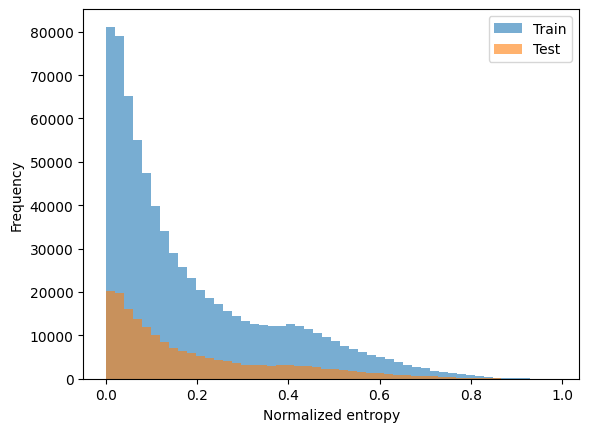

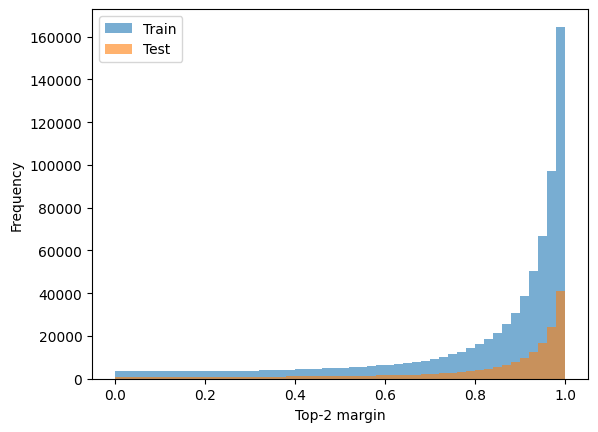

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# --- Extrair numpy arrays ---
entropy_train = contratos_train_val["entropy_norm"].to_numpy()
entropy_test  = contratos_test["entropy_norm"].to_numpy()

margin_train = contratos_train_val["top2_margin"].to_numpy()
margin_test  = contratos_test["top2_margin"].to_numpy()

# --- Distribuição da entropia normalizada ---
plt.figure()
plt.hist(entropy_train, bins=50, alpha=0.6, label="Train")
plt.hist(entropy_test, bins=50, alpha=0.6, label="Test")
plt.xlabel("Normalized entropy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- Distribuição da top-2 margin ---
plt.figure()
plt.hist(margin_train, bins=50, alpha=0.6, label="Train")
plt.hist(margin_test, bins=50, alpha=0.6, label="Test")
plt.xlabel("Top-2 margin")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
TYPE_COL = "Tipo(s) de contrato_LIMPO"   # <-- ajusta para a tua coluna
TOP_N = 12                   # nº de tipos a plotar (evita abrir 200 figuras)
BINS = 50

# (opcional mas recomendado) usar densidade para comparar formas (train/test têm tamanhos diferentes)
USE_DENSITY = True

# 1) escolher os TOP_N tipos mais frequentes no treino
top_types = (
    contratos_train_val
    .group_by(TYPE_COL)
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .head(TOP_N)[TYPE_COL]
    .to_list()
)

def plot_by_type(df_train, df_test, tipo):
    # filtrar
    tr = df_train.filter(pl.col(TYPE_COL) == tipo)
    te = df_test.filter(pl.col(TYPE_COL) == tipo)

    # extrair arrays
    ent_tr = tr["entropy_norm"].to_numpy()
    ent_te = te["entropy_norm"].to_numpy()

    mar_tr = tr["top2_margin"].to_numpy()
    mar_te = te["top2_margin"].to_numpy()

    # --- Entropia ---
    plt.figure()
    plt.hist(ent_tr, bins=BINS, alpha=0.6, label=f"Train (n={len(ent_tr)})", density=USE_DENSITY)
    plt.hist(ent_te, bins=BINS, alpha=0.6, label=f"Test (n={len(ent_te)})",  density=USE_DENSITY)
    plt.xlabel("Normalized entropy")
    plt.ylabel("Density" if USE_DENSITY else "Frequency")
    plt.title(f"Entropy — {tipo}")
    plt.legend()
    plt.show()

    # --- Top-2 margin ---
    plt.figure()
    plt.hist(mar_tr, bins=BINS, alpha=0.6, label=f"Train (n={len(mar_tr)})", density=USE_DENSITY)
    plt.hist(mar_te, bins=BINS, alpha=0.6, label=f"Test (n={len(mar_te)})",  density=USE_DENSITY)
    plt.xlabel("Top-2 margin")
    plt.ylabel("Density" if USE_DENSITY else "Frequency")
    plt.title(f"Top-2 margin — {tipo}")
    plt.legend()
    plt.show()

# 2) gerar plots por tipo
for t in top_types:
    plot_by_type(contratos_train_val, contratos_test, t)


In [98]:
P = 0.99

# calcular limiar P95 por tipo (APENAS no treino)
entropy_thresholds = (
    contratos_train_val
    .group_by(TYPE_COL)
    .agg(
        pl.col("entropy_norm")
        .quantile(P, interpolation="linear")
        .alias("entropy_p95")
    )
)


In [110]:
contratos_train_val = (
    contratos_train_val
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("entropy_norm") >= pl.col("entropy_p95"))
        .then(1)
        .otherwise(0)
        .alias("flag_entropy_p95")
    )
)

contratos_test = (
    contratos_test
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("entropy_norm") >= pl.col("entropy_p95"))
        .then(1)
        .otherwise(0)
        .alias("flag_entropy_p95")
    )
)


/tmp/ipykernel_3659013/3115346058.py:3: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")
/tmp/ipykernel_3659013/3115346058.py:14: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")


In [111]:
contratos_train_val.select(
    pl.col("flag_entropy_p95").mean().alias("share_flagged_train")
)

share_flagged_train
f64
0.010003


In [112]:
contratos_test.select(
    pl.col("flag_entropy_p95").mean().alias("share_flagged_test")
)

share_flagged_test
f64
0.010507


In [113]:
contratos_test.filter(
    pl.col("flag_entropy_p95")==1
).shape

(1970, 30)

In [116]:
contratos_test.filter(
    pl.col("flag_entropy_p95")==0
).to_pandas()["Objeto_LIMPO"].values[20:50]

array(['cp/2022/45_dega - "fiscalização, gestão de qualidade, coordenação de segurança em obra e coordenação de gestão ambiental da empreitada - abastecimento de água à senhorinha (paa-004) - sever do vouga',
       '231000160 - vários medicamentos',
       'aquisição de equipamento de educação física para espaços desportivos e escolares',
       'consultoria técnico-financeira para apoio à execução dos processos cofinanciados no âmbito do portugal 2020, através do progama operacional regional do centro',
       'pf 508/2019 - aquisição de serviços para elaboração de projeto de execução de "ampliação da rede de abastecimento de água a barbeitos"',
       'serviços de endoscopia - colonoscopias para a ulsba/epe',
       'pc 2021070343 electrodo',
       'aquisição de serviços de apoio e manutenção funcional do sap pacote de 500 horas.',
       'aquisição, configuração e instalação de equipamentos de switching (comutadores)',
       'aquisição de endoscópios.',
       '61/8022/2022 - aut

In [119]:
P = 0.05

# calcular limiar P95 por tipo (APENAS no treino)
entropy_thresholds = (
    contratos_train_val
    .group_by(TYPE_COL)
    .agg(
        pl.col("top2_margin")
        .quantile(P, interpolation="linear")
        .alias("top2_margin_p05")
    )
)


In [120]:
contratos_train_val = (
    contratos_train_val
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("top2_margin") <= pl.col("top2_margin_p05"))
        .then(1)
        .otherwise(0)
        .alias("flag_top2_margin_05")
    )
)

contratos_test = (
    contratos_test
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("top2_margin") <= pl.col("top2_margin_p05"))
        .then(1)
        .otherwise(0)
        .alias("flag_top2_margin_05")
    )
)


/tmp/ipykernel_3659013/2470258726.py:3: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")
/tmp/ipykernel_3659013/2470258726.py:14: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")


In [135]:
contratos_test.filter(pl.col("top2_margin")>0.8).to_pandas()[["Objeto_LIMPO", "probs"]].values[:20]

array([['aquisição de serviços de conformidade legal',
        array([0.03082978, 0.93332374, 0.02276498, 0.00251126, 0.00721273,
               0.00335751])                                               ],
       ['191g002020',
        array([9.92837456e-01, 1.66580594e-03, 6.70857163e-07, 1.78243125e-07,
               1.66882072e-06, 5.49422037e-03])                               ],
       ['aquisição do medicamento ao fornecedor merck, s.a. a pedido da farmácia de modo a cobrir as necessidades reportadas para o presente ano pelos serviços do hb',
        array([2.28959219e-04, 9.77840749e-01, 8.48239563e-05, 2.15436418e-02,
               2.61488882e-04, 4.03366538e-05])                               ],
       ['ritonavir 100 mg comp (procedimento nº 1193820)',
        array([0.94374725, 0.02626353, 0.00325433, 0.00163589, 0.00155211,
               0.0235469 ])                                               ],
       ['2022020207 - 7mm e 7.5mm portex tracheal tube',
        array([

In [137]:
contratos_test.filter(pl.col("flag_top2_margin_05")==1).to_pandas()[["Objeto_LIMPO", "Tipo(s) de contrato_LIMPO", "probs"]].values[:20]

array([['aquisição de serviços de publicidade, divulgação e cobertura de eventos e atividades',
        'aquisição de serviços',
        array([0.31811552, 0.43366887, 0.00440313, 0.04982143, 0.11974934,
               0.07424171])                                               ],
       ['npd 3019001024_das - nos - internet', 'aquisição de serviços',
        array([0.41777894, 0.52917022, 0.01028739, 0.00983167, 0.00397918,
               0.0289526 ])                                               ],
       ['aquisição de serviços de "consultoria para o projeto clarin-pt para o desenvolvimento de um conjunto de recursos e ferramentas"',
        'aquisição de serviços',
        array([0.15592554, 0.42051779, 0.01329281, 0.0395334 , 0.3600428 ,
               0.01068766])                                               ],
       ['prestação de serviços relativa ao layout (mobiliário expositivo, conceção de painéis interpretativos e catálogo) para duas exposições para o museu de artes decora

In [ ]:
# contracto_train = contratos[idx_train_val]

# TH = 0.4

# confidence = y_proba_train.max(axis=1)
# pred_idx = y_proba_train.argmax(axis=1)                   
# pred_label = model.classes_[pred_idx]                    
# pred_label_name = le.inverse_transform(pred_label)

# contrato_train2 = (
#     contracto_train
#     .with_columns([
#         pl.Series("model_confidence", confidence),
#         pl.Series("model_prediction", pred_label_name),
#     ])
# )

# low_conf = (
#     contrato_train2
#     .filter(pl.col("model_confidence") < TH)
#     .sort("model_confidence")
# )

# low_conf_pd = low_conf.to_pandas()

In [ ]:
# TH = 0.8

# high_conf = (
#     contrato_train2
#     .filter(pl.col("model_confidence") > TH)
#     .sort("model_confidence")
# )

# high_conf_pd = high_conf.to_pandas()

In [ ]:
# contrato_test = contratos[idx_test]

# TH = 0.4

# confidence = y_proba_test.max(axis=1)
# pred_idx = y_proba_test.argmax(axis=1)                   
# pred_label = model.classes_[pred_idx]                     
# pred_label_name = le.inverse_transform(pred_label)

# contrato_test2 = (
#     contrato_test
#     .with_columns([
#         pl.Series("model_confidence_logistic", confidence),
#         pl.Series("model_prediction_logistic", pred_label_name),
#     ]). \
#     with_columns(
#         pl.when((pl.col("model_confidence_logistic") < TH)).then(pl.lit(1)).otherwise(pl.lit(0)).alias("flag_1011_model_logistic")
#     )
# )

In [ ]:
# contrato_test2.write_parquet("../../data/results_object_indicator.parquet")

In [141]:
contratos_train_val.select(['N.º Procedimento (ID BASE)', 'N.º Contrato', 'flag_1011_anom',
 'dist_serafim_obj_tipo',
 'dist_labse_obj_tipo',
 'flag_1011_serafim',
 'flag_1011_labse',
 'flag_1011_dist',
 'probs',
 'entropy',
 'entropy_norm',
 'entropy_p95',
 'flag_entropy_p95',
 'top2_margin',
 'top2_margin_p05'
 ]).write_ipc("../../data/contratos_train_val_logistic.arrow")

contratos_test.select(['N.º Procedimento (ID BASE)', 'N.º Contrato', 'flag_1011_anom',
 'dist_serafim_obj_tipo',
 'dist_labse_obj_tipo',
 'flag_1011_serafim',
 'flag_1011_labse',
 'flag_1011_dist',
 'probs',
 'entropy',
 'entropy_norm',
 'entropy_p95',
 'flag_entropy_p95',
 'top2_margin',
 'top2_margin_p05'
 ]).write_ipc("../../data/contratos_test_logistic.arrow")

### XGBoost

In [142]:
# e se prevê com muita confiança mas prevê mal???

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",

    max_depth=3,
    min_child_weight=5,
    gamma=1.0,

    subsample=0.8,
    colsample_bytree=0.7,

    learning_rate=0.05,
    n_estimators=500,

    reg_alpha=0.5,
    reg_lambda=1.5,

    random_state=SEED,
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)

y_pred_train = model.predict(X_serafim_train_val)
y_pred_test = model.predict(X_serafim_test)

In [143]:
# cálculo da confiança para cada observação
y_proba_train = model.predict_proba(X_serafim_train_val)
y_proba_test = model.predict_proba(X_serafim_test)

In [144]:
print(classification_report(y_train_encoded, y_pred_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94    393180
           1       0.90      0.89      0.90    292876
           2       0.09      0.70      0.16       309
           3       0.46      0.86      0.60       491
           4       0.84      0.78      0.81     55021
           5       0.43      0.55      0.48      8067

    accuracy                           0.91    749944
   macro avg       0.61      0.79      0.65    749944
weighted avg       0.91      0.91      0.91    749944



In [145]:
print(classification_report(y_test_encoded, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     98296
           1       0.90      0.89      0.89     73219
           2       0.01      0.09      0.02        77
           3       0.42      0.67      0.51       123
           4       0.83      0.77      0.80     13755
           5       0.42      0.54      0.47      2017

    accuracy                           0.90    187487
   macro avg       0.59      0.65      0.61    187487
weighted avg       0.91      0.90      0.91    187487



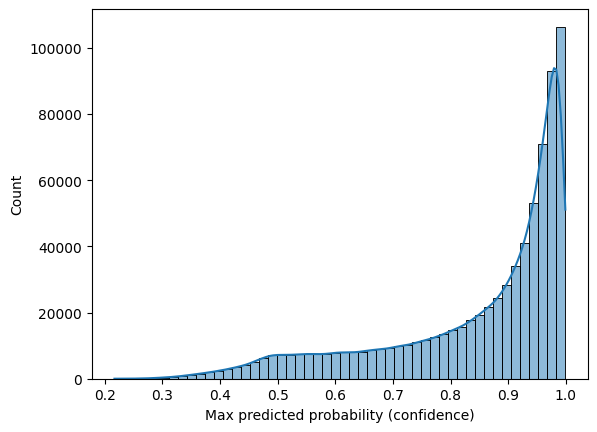

In [146]:
# ver qual é a distribuição confiança do modelo no que toca à classe vitoriosa
p_victorious = y_proba_train.max(axis=1)
sns.histplot(p_victorious, bins=50, kde=True)
plt.xlabel("Max predicted probability (confidence)")
plt.show()

In [147]:
contratos_train_val = contratos_train_val.with_columns(
    pl.Series(
        name="probs_xgb",
        values=y_proba_train.tolist()
    )
)

contratos_test = contratos_test.with_columns(
    pl.Series(
        name="probs_xgb",
        values=y_proba_test.tolist()
    )
)

In [149]:
EPS = 1e-12
K = y_proba_train.shape[1]

contratos_train_val = contratos_train_val.with_columns([
    # Entropia
    (
        pl.col("probs_xgb")
        .list.eval(
            pl.element().clip(EPS, 1.0).log() * pl.element()
        )
        .list.sum()
        .mul(-1)
    ).alias("entropy_xgb"),

    (
        pl.col("probs_xgb")
        .list.sort(descending=True)
        .list.get(0)
        -
        pl.col("probs_xgb")
        .list.sort(descending=True)
        .list.get(1)
    ).alias("top2_margin_xgb"),
]).with_columns(
    # Entropia normalizada
    (pl.col("entropy_xgb") / np.log(K)).alias("entropy_norm_xgb"),
)

In [150]:
contratos_test = contratos_test.with_columns([
    (
        pl.col("probs_xgb")
        .list.eval(
            pl.element().clip(EPS, 1.0).log() * pl.element()
        )
        .list.sum()
        .mul(-1)
    ).alias("entropy_xgb"),


    (
        pl.col("probs_xgb")
        .list.sort(descending=True)
        .list.get(0)
        -
        pl.col("probs_xgb")
        .list.sort(descending=True)
        .list.get(1)
    ).alias("top2_margin_xgb"),
]).with_columns(
    (pl.col("entropy_xgb") / np.log(K)).alias("entropy_norm_xgb"),

)


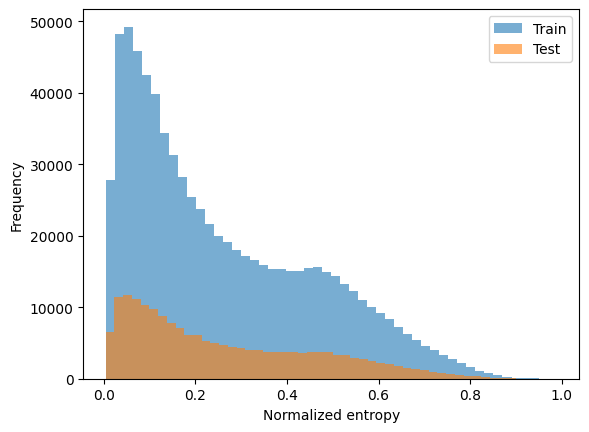

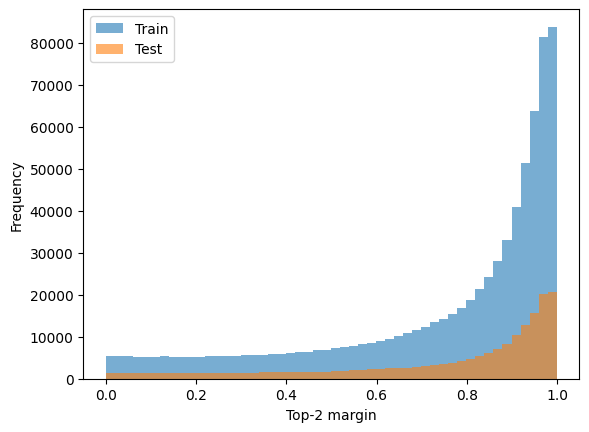

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# --- Extrair numpy arrays ---
entropy_train = contratos_train_val["entropy_norm_xgb"].to_numpy()
entropy_test  = contratos_test["entropy_norm_xgb"].to_numpy()

margin_train = contratos_train_val["top2_margin_xgb"].to_numpy()
margin_test  = contratos_test["top2_margin_xgb"].to_numpy()

# --- Distribuição da entropia normalizada ---
plt.figure()
plt.hist(entropy_train, bins=50, alpha=0.6, label="Train")
plt.hist(entropy_test, bins=50, alpha=0.6, label="Test")
plt.xlabel("Normalized entropy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- Distribuição da top-2 margin ---
plt.figure()
plt.hist(margin_train, bins=50, alpha=0.6, label="Train")
plt.hist(margin_test, bins=50, alpha=0.6, label="Test")
plt.xlabel("Top-2 margin")
plt.ylabel("Frequency")
plt.legend()
plt.show()


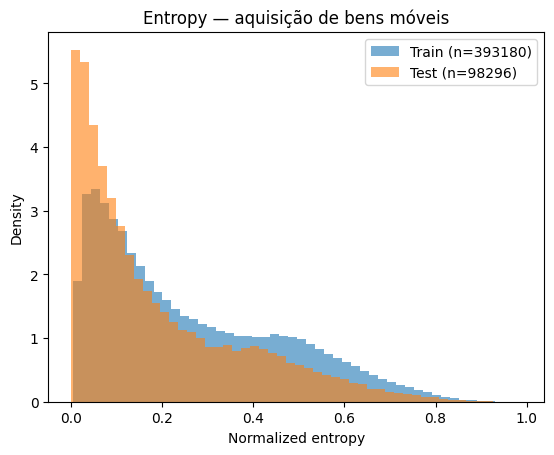

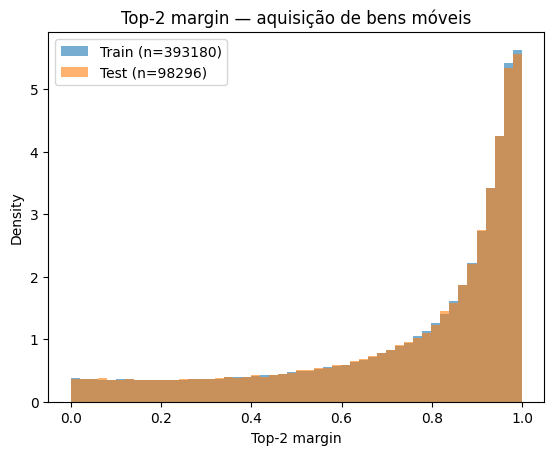

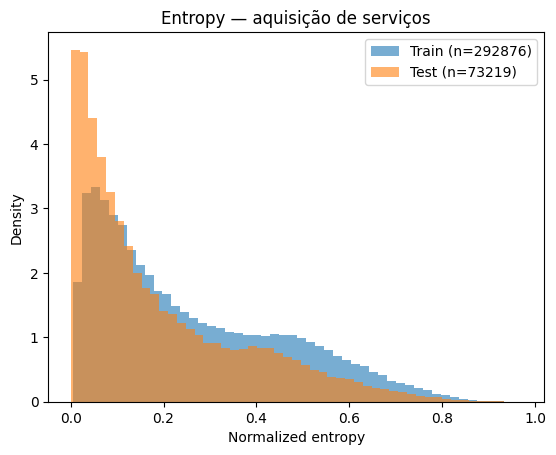

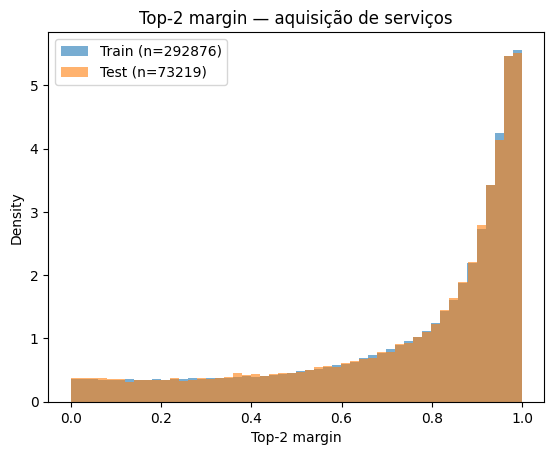

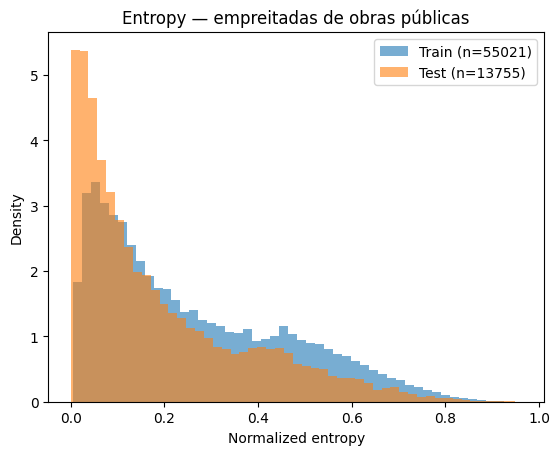

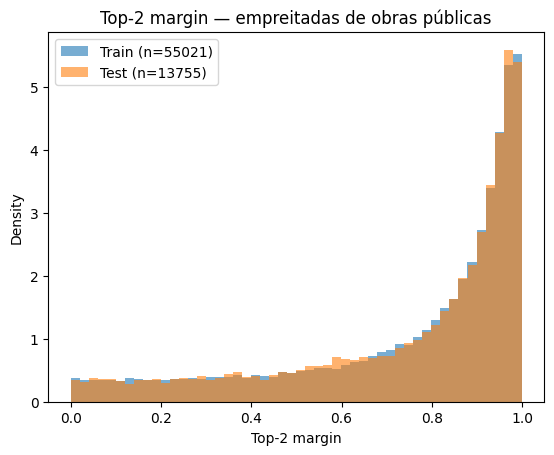

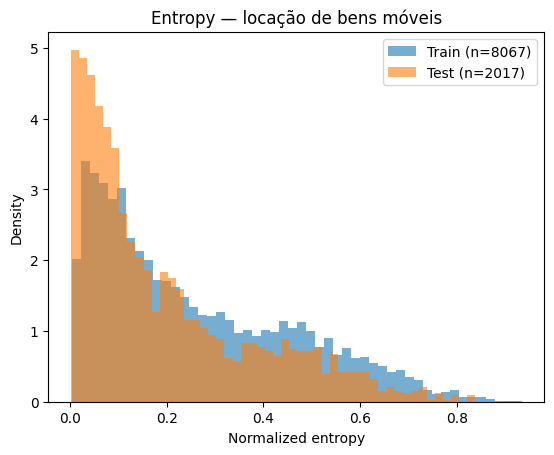

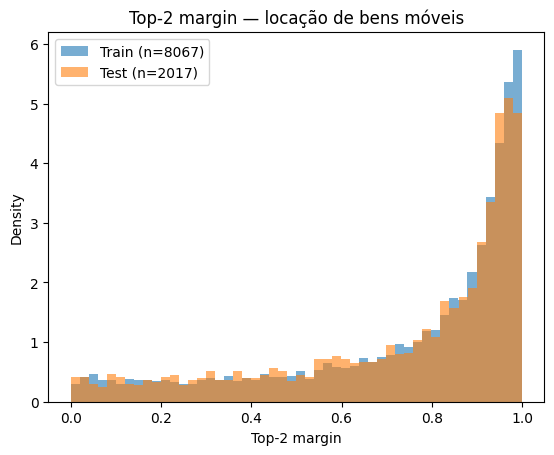

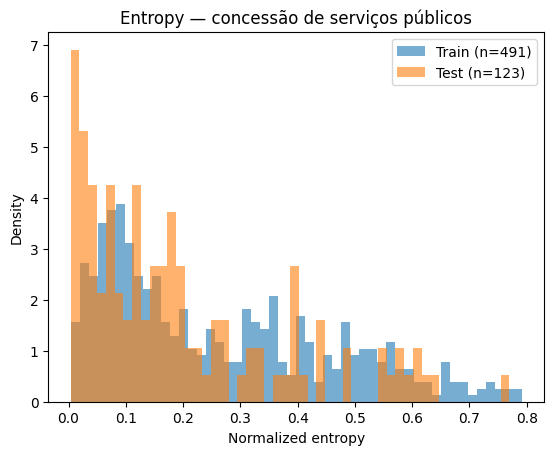

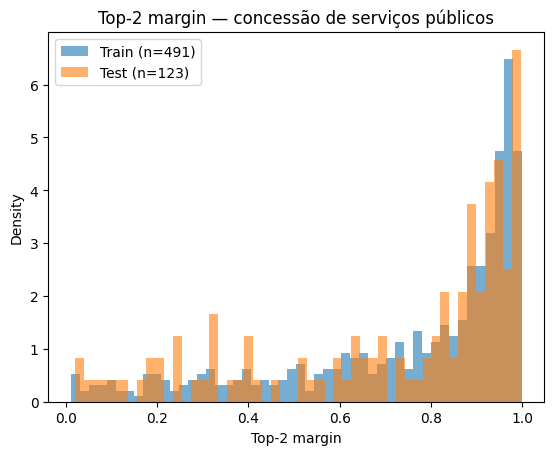

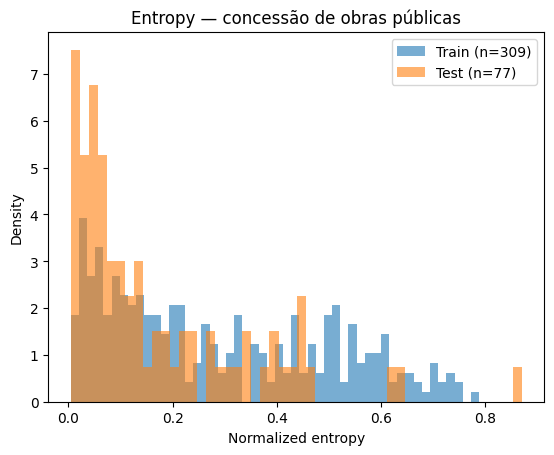

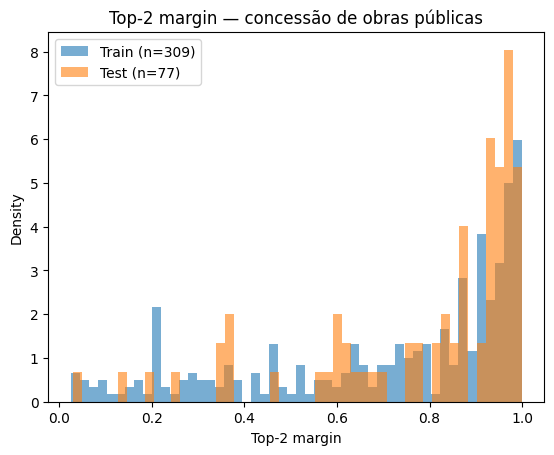

In [152]:
TYPE_COL = "Tipo(s) de contrato_LIMPO"   # <-- ajusta para a tua coluna
TOP_N = 12                   # nº de tipos a plotar (evita abrir 200 figuras)
BINS = 50

# (opcional mas recomendado) usar densidade para comparar formas (train/test têm tamanhos diferentes)
USE_DENSITY = True

# 1) escolher os TOP_N tipos mais frequentes no treino
top_types = (
    contratos_train_val
    .group_by(TYPE_COL)
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .head(TOP_N)[TYPE_COL]
    .to_list()
)

def plot_by_type(df_train, df_test, tipo):
    # filtrar
    tr = df_train.filter(pl.col(TYPE_COL) == tipo)
    te = df_test.filter(pl.col(TYPE_COL) == tipo)

    # extrair arrays
    ent_tr = tr["entropy_norm_xgb"].to_numpy()
    ent_te = te["entropy_norm"].to_numpy()

    mar_tr = tr["top2_margin_xgb"].to_numpy()
    mar_te = te["top2_margin_xgb"].to_numpy()

    # --- Entropia ---
    plt.figure()
    plt.hist(ent_tr, bins=BINS, alpha=0.6, label=f"Train (n={len(ent_tr)})", density=USE_DENSITY)
    plt.hist(ent_te, bins=BINS, alpha=0.6, label=f"Test (n={len(ent_te)})",  density=USE_DENSITY)
    plt.xlabel("Normalized entropy")
    plt.ylabel("Density" if USE_DENSITY else "Frequency")
    plt.title(f"Entropy — {tipo}")
    plt.legend()
    plt.show()

    # --- Top-2 margin ---
    plt.figure()
    plt.hist(mar_tr, bins=BINS, alpha=0.6, label=f"Train (n={len(mar_tr)})", density=USE_DENSITY)
    plt.hist(mar_te, bins=BINS, alpha=0.6, label=f"Test (n={len(mar_te)})",  density=USE_DENSITY)
    plt.xlabel("Top-2 margin")
    plt.ylabel("Density" if USE_DENSITY else "Frequency")
    plt.title(f"Top-2 margin — {tipo}")
    plt.legend()
    plt.show()

# 2) gerar plots por tipo
for t in top_types:
    plot_by_type(contratos_train_val, contratos_test, t)


In [153]:
P = 0.99

# calcular limiar P95 por tipo (APENAS no treino)
entropy_thresholds = (
    contratos_train_val
    .group_by(TYPE_COL)
    .agg(
        pl.col("entropy_norm_xgb")
        .quantile(P, interpolation="linear")
        .alias("entropy_p95_xgb")
    )
)


In [154]:
contratos_train_val = (
    contratos_train_val
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("entropy_norm_xgb") >= pl.col("entropy_p95_xgb"))
        .then(1)
        .otherwise(0)
        .alias("flag_entropy_p95_xgb")
    )
)

contratos_test = (
    contratos_test
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("entropy_norm_xgb") >= pl.col("entropy_p95_xgb"))
        .then(1)
        .otherwise(0)
        .alias("flag_entropy_p95_xgb")
    )
)


/tmp/ipykernel_3659013/1217382563.py:3: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")
/tmp/ipykernel_3659013/1217382563.py:14: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")


In [155]:
P = 0.05

# calcular limiar P95 por tipo (APENAS no treino)
entropy_thresholds = (
    contratos_train_val
    .group_by(TYPE_COL)
    .agg(
        pl.col("top2_margin_xgb")
        .quantile(P, interpolation="linear")
        .alias("top2_margin_p05_xgb")
    )
)

In [156]:
contratos_train_val = (
    contratos_train_val
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("top2_margin_xgb") <= pl.col("top2_margin_p05_xgb"))
        .then(1)
        .otherwise(0)
        .alias("flag_top2_margin_05_xgb")
    )
)

contratos_test = (
    contratos_test
    .join(entropy_thresholds, on=TYPE_COL, how="left")
    .with_columns(
        pl.when(pl.col("top2_margin_xgb") <= pl.col("top2_margin_p05_xgb"))
        .then(1)
        .otherwise(0)
        .alias("flag_top2_margin_05_xgb")
    )
)


/tmp/ipykernel_3659013/3658795880.py:3: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")
/tmp/ipykernel_3659013/3658795880.py:14: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  .join(entropy_thresholds, on=TYPE_COL, how="left")


In [165]:
contratos_test.filter(pl.col("flag_entropy_p95_xgb")==0).to_pandas()["Objeto_LIMPO"]

0               aquisição de serviços de conformidade legal
1              2022000746 - sie - filtro para máquina miele
2                                                191g002020
3         aquisição do medicamento ao fornecedor merck, ...
4           ritonavir 100 mg comp (procedimento nº 1193820)
                                ...                        
185525    contrato de manutenção e assistência técnica a...
185526                     reparação de bomba de circulação
185527    procedimento n.º 040139962018 - pomalidomida 2...
185528    implementação de uma ferramenta de gestão docu...
185529    «aquisição de serviços de viagens e alojamento...
Name: Objeto_LIMPO, Length: 185530, dtype: object

### LightLM

In [55]:
model = LGBMClassifier(random_state = SEED)


model.fit(X_train_res, y_train_res)


y_pred_train = model.predict(X_serafim_train_val)
y_pred_test = model.predict(X_serafim_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 859358, number of used features: 1024
[LightGBM] [Info] Start training from score -0.781857
[LightGBM] [Info] Start training from score -1.076201
[LightGBM] [Info] Start training from score -3.083258
[LightGBM] [Info] Start training from score -3.082928
[LightGBM] [Info] Start training from score -2.748162
[LightGBM] [Info] Start training from score -3.081811


In [56]:
print(classification_report(y_train_encoded, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    393204
           1       0.92      0.91      0.92    292945
           2       0.66      0.99      0.79       309
           3       0.77      0.98      0.86       491
           4       0.87      0.86      0.86     55038
           5       0.51      0.63      0.56      8070

    accuracy                           0.93    750057
   macro avg       0.78      0.89      0.82    750057
weighted avg       0.93      0.93      0.93    750057



In [57]:
print(classification_report(y_test_encoded, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     98301
           1       0.91      0.90      0.91     73237
           2       0.06      0.04      0.05        77
           3       0.60      0.62      0.61       123
           4       0.85      0.83      0.84     13760
           5       0.45      0.55      0.50      2017

    accuracy                           0.92    187515
   macro avg       0.64      0.65      0.64    187515
weighted avg       0.92      0.92      0.92    187515



## 4. Try and use an LLM to flag contracts

In [ ]:
# quero fazer isto para contratos que têm o single biding
# e contratos em que consegui extrair o caderno de encargos

In [92]:
contratos_aux = pl.read_csv("../../data/impic_data/contratos.csv",
                        separator=";",
                        schema_overrides=contracts_schema(),
                        columns=[
                            "N.º Procedimento (ID BASE)", 'N.º Contrato', 'Tipo de procedimento'
                        ]).unique(subset=["N.º Procedimento (ID BASE)", 'N.º Contrato'])

In [ ]:
single_biding_indicator = pl.read_ipc("../../data/indicators/indicator_1016.arrow")

In [93]:
contratos = contratos.join(contratos_aux, how="left", on = ["N.º Procedimento (ID BASE)", 'N.º Contrato'], coalesce=True)

# ler o dataset, colocar no prompt do LLM a diretiva, ou os problemas no objeto do contrato e depois ver se ele consegue identificar algum problema


In [96]:
contratos

row_id,N.º Procedimento (ID BASE),N.º Contrato,Tipo(s) de contrato_LIMPO,Objeto_LIMPO,Objeto_LIMPO_2,Objeto,Tipo de procedimento,Objeto_LIMPO_2_len,Data Celebração,Local de execução das principais prestações objeto do contrato,ano_celebração,flag_1011,dist_serafim_obj_tipo,Tipo de procedimento_right
u32,str,str,str,str,str,str,str,u32,date,str,i32,i32,f64,str
2,"""6398667""","""9923128""","""aquisição de bens móveis""","""diverso material para as aulas…","""diverso material aulas prática…","""Diverso Material para as aulas…","""Consulta Prévia""",61,2023-03-30,"""Portugal, Porto, Santo Tirso""",2023,0,0.566105,"""Consulta Prévia"""
17,"""6513274""","""10017233""","""locação de bens móveis""","""ajuste direto para aluguer de …","""ajuste direto aluguer contento…","""Ajuste Direto para Aluguer de …","""Ajuste Direto Regime Geral""",104,2023-05-12,"""Portugal, Porto, Matosinhos""",2023,0,0.518973,"""Ajuste Direto Regime Geral"""
18,"""6648000""","""10256353""","""locação de bens móveis""","""aluguer de detetores de gases""","""aluguer detetores gases""","""Aluguer de Detetores de Gases""","""Ajuste Direto Regime Geral""",23,2023-09-20,"""Portugal, Porto, Porto""",2023,0,0.490476,"""Ajuste Direto Regime Geral"""
29,"""6731323""","""10344805""","""aquisição de serviços""","""prestação de serviços de técni…","""prestação serviços técnico dep…","""PRESTAÇÃO DE SERVIÇOS DE TÉCNI…","""Consulta Prévia""",97,2023-11-15,"""Portugal, Setúbal, Setúbal""",2023,0,0.478935,"""Consulta Prévia"""
30,"""6813061""","""10388439""","""aquisição de serviços""","""desempenho de funções no âmbit…","""desempenho funções âmbito doma…","""DESEMPENHO DE FUNÇÕES NO ÂMBIT…","""Ajuste Direto Regime Geral""",63,2023-12-13,"""Portugal, Braga, Póvoa de Lanh…",2023,0,0.578998,"""Ajuste Direto Regime Geral"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
937828,"""6348678""","""9952080""","""aquisição de serviços""","""prestação de serviços de ortop…","""prestação serviços ortopedia t…","""PRESTAÇÃO DE SERVIÇOS DE ORTOP…","""Concurso público""",109,2023-04-28,"""Portugal, Lisboa, Lisboa""",2023,0,0.674237,"""Concurso público"""
937836,"""6645047""","""10182227""","""aquisição de serviços""","""desenvolvimento do portal autá…","""desenvolvimento portal autárqu…","""DESENVOLVIMENTO DO PORTAL AUTÁ…","""Consulta Prévia""",79,2023-08-08,"""Portugal, Região Autónoma dos …",2023,0,0.545266,"""Consulta Prévia"""
937838,"""6734498""","""10416145""","""aquisição de serviços""","""manutenção de equipamentos e s…","""manutenção equipamentos servid…","""MANUTENÇÃO DE EQUIPAMENTOS E S…","""Concurso público""",40,2023-12-20,"""Portugal, Lisboa, Lisboa""",2023,0,0.544209,"""Concurso público"""


In [ ]:
# contratos_to_llm = deepcopy(contratos_sem_outros.to_pandas().iloc[idx_test])#[['N.º Contrato', 'Objeto_LIMPO']])

In [ ]:
# só vou avaliar os contratos que têm como tipo de procedimento concursos públicos
contratos_to_llm = contratos[contratos['Tipo de procedimento']=='Concurso público'][["N.º Procedimento (ID BASE)", "N.º Contrato", "Objeto_LIMPO", "Tipo(s) de contrato_LIMPO"]].copy()

contratos_to_llm.rename(columns={"N.º Procedimento (ID BASE)": "Num", 'N.º Contrato': 'ID', 'Objeto_LIMPO': 'Objeto'}, inplace=True)
items = contratos_to_llm.to_dict('records')

In [ ]:
Label = Literal["Aquisição de bens móveis", "Aquisição de serviços", "Locação de bens móveis", "Empreitadas de obras públicas", "Concessão de serviços públicos", "Concessão de obras públicas"]

class ItemResult(BaseModel):
    num: str
    id: str
    label: Label

In [ ]:
models = ['gemma3:27b', "mistral-small3.2:24b"]

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system",
     "És um auditor de contratação pública e o teu objetivo é associar objetos contratuais à sua tipologia."
     "Devolve APENAS JSON válido correspondente ao schema pedido. "
     "Nunca incluas texto fora do JSON."),
    ("user",
     "Associa o objeto contratual seguinte a uma destas categorias {labels} e devolve "
     "JSON com 'num', 'id' e 'label'. \n\n"
     "num={Num}\nid={ID}\nobjeto={Objeto}")
])

labels_str = list(Label.__args__)
inputs = [{"Num": x["Num"], "ID": x["ID"], "Objeto": x["Objeto"], "labels": labels_str} for x in items]

B = 64
MAX_CONCURRENCY = 6

all_rows = []   # list of dicts: {"model":..., "num":..., "id":..., "label":...}
meta_rows = []  # model-level run metadata

for model in models:
    llm = ChatOllama(model=model, temperature=0)
    structured_llm = llm.with_structured_output(ItemResult, method="json_schema")
    chain = prompt | structured_llm

    t0 = time.time()
    errors = 0
    produced = 0

    for i in tqdm(range(0, len(inputs), B), desc=f"Model: {model}"):
        chunk = inputs[i:i+B]
        try:
            out = chain.batch(chunk, config={"max_concurrency": MAX_CONCURRENCY})
            produced += len(out)

            for inp, pred in zip(chunk, out):
                # pred is ItemResult (pydantic). Convert to dict safely.
                pred_d = pred.model_dump() if hasattr(pred, "model_dump") else dict(pred)

                all_rows.append({
                    "model": model,
                    "num": pred_d.get("num", inp["Num"]),
                    "id": pred_d.get("id", inp["ID"]),
                    "label": pred_d.get("label"),
                })
        except Exception:
            errors += 1
            # optional: fallback to per-item processing so you don't lose the whole batch
            for inp in chunk:
                try:
                    one = chain.invoke(inp)
                    pred_d = one.model_dump() if hasattr(one, "model_dump") else dict(one)
                    all_rows.append({
                        "model": model,
                        "num": pred_d.get("num", inp["Num"]),
                        "id": pred_d.get("id", inp["ID"]),
                        "label": pred_d.get("label"),
                    })
                    produced += 1
                except Exception:
                    all_rows.append({
                        "model": model,
                        "num": inp["Num"],
                        "id": inp["ID"],
                        "label": None,
                    })

    meta_rows.append({
        "model": model,
        "n_inputs": len(inputs),
        "n_produced": produced,
        "batch_errors": errors,
        "seconds": time.time() - t0,
    })

In [ ]:
# agregar os resultados dos dois LLMs
resultados = pl.DataFrame(all_rows)
resultados_gema = deepcopy(resultados[resultados['model']=='gemma3:27b'].rename(columns={'label': 'label_gema'}))
resultados_mistral = deepcopy(resultados[resultados['model']=='mistral-small3.2:24b'].rename(columns={'label': 'label_mistral'}))
resultados_final_llm = resultados_gema[['num', 'id', 'label_gema']].merge(resultados_mistral[['num', 'id', 'label_mistral']], on=['num', 'id'])

In [ ]:
resultados.write_parquet("../../data/results_llm.parquet")

In [ ]:
resultados_final_llm.write_par("../../data/results_llm.arrow")

In [ ]:
contratos_sem_outros = contratos_sem_outros.to_pandas()